In [1]:
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("en_core_web_sm")

from transformers import AutoModelForQuestionAnswering, AutoTokenizer

In [37]:
def plot_binned_score(df, column_name, bins, xlab):
    col  = ['EM', 'F1', 'count', column_name]
#     bins = list(np.arange(df[column_name].min(), df[column_name].max(), n)) #+ [np.inf]
 
    df_binned     = df.groupby(pd.cut(df[column_name],bins=bins))[col].mean()
    df_binned_sum = df.groupby(pd.cut(df[column_name],bins=bins))[col].sum()
    
    assert (df_binned.index == df_binned_sum.index).all()

    assert df_binned.shape == df_binned_sum.shape

    df_binned.dropna(inplace=True)
    df_binned_sum.dropna(inplace=True)
    df_binned_sum = df_binned_sum[df_binned_sum['count']!=0]
        
    assert df_binned.shape == df_binned_sum.shape

    plt.figure(figsize=(10,8))
    plt.plot(df_binned[column_name].values, df_binned['F1'].values, 'o-', label = 'Partial Match')
    plt.plot(df_binned[column_name].values, df_binned['EM'].values, 'o-', label = 'Exact Match')

    plt.legend(loc="lower left", prop={'size': 14})
    plt.xticks(df_binned[column_name].values, list(df_binned.index),
               fontsize=12, rotation = 60)
    plt.yticks(fontsize=12, rotation = 0)
    plt.ylim(0,1)
    plt.xlabel(f'Bins of "{xlab}" count', fontsize=15)
    plt.ylabel('Performance Score', fontsize=15)
#     plt.title(column_name)
    
    a = plt.axes([.69, .67, .2, .2], facecolor='white')
    plt.bar(df_binned[column_name].values, df_binned_sum['count'].values, 
#             color = 'b',
            alpha = 1,
            width = 3,
#             label = 'Sample Count'
           )
#     plt.legend(loc="best",prop={'size': 10})
    plt.xlabel(f'Average value\nwithin the bins', fontsize=12)
    plt.ylabel('Count', fontsize=12)
#     plt.xticks(df_binned_sum[column_name].values, list(df_binned_sum.index), rotation = 60)
    plt.yticks(rotation = 0)

    plt.show()
    
    print(df_binned_sum['count'].values)
    
    return df_binned


In [18]:
df_path = '/net/kdinxidk03/opt/NFS/75y/data/qa/output/'
# df = pd.read_csv(df_path+'results_bert-base-uncased-squad-v1_384_otquad.csv')
df = pd.read_csv(df_path+'results_bart-squad-v1_512_otquad.csv')

df['EM'].mean()

0.74

In [19]:
# cached_features_file = os.path.join(
#     df_path,
#     "cached_{}_{}_{}_{}_{}".format(
#         "dev",
#         "bert-base-uncased-squad-v1",
#         384,
#         "test",
#         "otquad",
#     ),
# )

cached_features_file = os.path.join(
    df_path,
    "cached_{}_{}_{}_{}_{}".format(
        "dev",
        "bart-squad-v1",
        512,
        "test",
        "otquad",
    ),
)

# Init features and dataset from cache if it exists
features_and_dataset = torch.load(cached_features_file)
_, _, examples = (
    features_and_dataset["features"],
    features_and_dataset["dataset"],
    features_and_dataset["examples"],
)

In [20]:
# model_name = 'csarron/bert-base-uncased-squad-v1'
model_name = 'a-ware/bart-squadv2'

model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
answers = [ex.__dict__['answers'][0]['text'] for ex in examples]
answer_char_count = [len(ans) for ans in answers]
# answer_word_count = [len(nlp(ans)) for ans in answers]
answer_word_count = [len(tokenizer.tokenize(ans)) for ans in answers]
count = [1]*len(answers)

In [22]:
contexts = [ex.__dict__['context_text'] for ex in examples]
context_char_count = [len(x) for x in contexts]
# context_word_count = [len(nlp(ans)) for ans in contexts]
context_word_count = [len(tokenizer.tokenize(x)) for x in contexts]

df['contexts'] = contexts
df['context_char_count'] = context_char_count
df['context_word_count'] = context_word_count

In [23]:
df['answers'] = answers
df['answer_char_count'] = answer_char_count
df['answer_word_count'] = answer_word_count
df['count'] = count

In [24]:
stat = df['context_word_count'].describe()
stat

count    150.000000
mean     228.980000
std       88.063314
min       48.000000
25%      154.000000
50%      261.000000
75%      311.000000
max      416.000000
Name: context_word_count, dtype: float64

In [25]:
stat = df['answer_word_count'].describe()
stat

count    150.000000
mean      17.693333
std       26.902745
min        2.000000
25%        6.000000
50%       11.000000
75%       18.000000
max      201.000000
Name: answer_word_count, dtype: float64

In [26]:
col  = ['EM', 'F1', 'count', 'context_word_count', 'context_char_count']
# bins = list(np.arange(df['answer_word_count'].min(), df['answer_word_count'].max(), 5)) + [np.inf]
bins = [0,
#         2, 4, 
        stat['25%'],
        stat['50%'],
#         14,
        stat['75%'],
#         30,
        stat['max']]

In [27]:
col  = ['EM', 'F1', 'count', 'answer_word_count', 'answer_char_count']
# bins = list(np.arange(df['answer_word_count'].min(), df['answer_word_count'].max(), 5)) + [np.inf]
bins = [0,
#         2, 4,
        4,
        stat['25%'],
        8,
        stat['50%'],
        14,
        stat['75%'],
        30,
        stat['max']]

In [28]:
# df.sample(5)

In [29]:
df_binned_sum = df.groupby(pd.cut(df['answer_word_count'],bins=bins))['count'].sum()
df_binned_sum

answer_word_count
(0.0, 4.0]       24
(4.0, 6.0]       24
(6.0, 8.0]       17
(8.0, 11.0]      15
(11.0, 14.0]     17
(14.0, 18.0]     17
(18.0, 30.0]     20
(30.0, 201.0]    16
Name: count, dtype: int64

In [30]:
df_binned_mean = df.groupby(pd.cut(df['answer_word_count'],bins=bins))[col].mean()
df_binned_mean

,EM,F1,count,answer_word_count,answer_char_count
answer_word_count,,,,,
"(0.0, 4.0]",0.875000,0.923611,1.0,3.208333,14.916667
"(4.0, 6.0]",0.833333,0.908601,1.0,5.541667,27.000000
"(6.0, 8.0]",0.705882,0.782446,1.0,7.529412,34.470588
"(8.0, 11.0]",0.466667,0.570370,1.0,10.733333,59.466667
"(11.0, 14.0]",0.882353,0.960208,1.0,13.000000,53.647059
"(14.0, 18.0]",0.882353,0.975335,1.0,16.529412,77.058824
"(18.0, 30.0]",0.750000,0.909142,1.0,23.100000,117.150000
"(30.0, 201.0]",0.375000,0.571849,1.0,74.437500,374.812500


In [31]:
# plot_binned_score(df, 'context_word_count', bins, "word count in contexts")

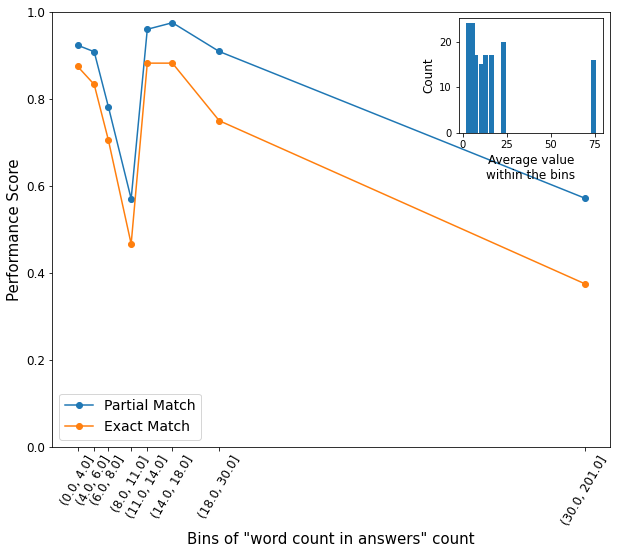

[24 24 17 15 17 17 20 16]


,EM,F1,count,answer_word_count
answer_word_count,,,,
"(0.0, 4.0]",0.875000,0.923611,1.0,3.208333
"(4.0, 6.0]",0.833333,0.908601,1.0,5.541667
"(6.0, 8.0]",0.705882,0.782446,1.0,7.529412
"(8.0, 11.0]",0.466667,0.570370,1.0,10.733333
"(11.0, 14.0]",0.882353,0.960208,1.0,13.000000
"(14.0, 18.0]",0.882353,0.975335,1.0,16.529412
"(18.0, 30.0]",0.750000,0.909142,1.0,23.100000
"(30.0, 201.0]",0.375000,0.571849,1.0,74.437500


In [38]:
plot_binned_score(df, 'answer_word_count', bins, "word count in answers")

Exact Match
This metric is as simple as it sounds. For each question+answer pair, if the characters of the model's prediction exactly match the characters of (one of) the True Answer(s), EM = 1, otherwise EM = 0. This is a strict all-or-nothing metric; being off by a single character results in a score of 0. When assessing against a negative example, if the model predicts any text at all, it automatically receives a 0 for that example.

F1 score is a common metric for classification problems, and widely used in QA. It is appropriate when we care equally about precision and recall. In this case, it's computed over the individual words in the prediction against those in the True Answer. The number of shared words between the prediction and the truth is the basis of the F1 score: precision is the ratio of the number of shared words to the total number of words in the prediction, and recall is the ratio of the number of shared words to the total number of words in the ground truth.

